# Project 05 - Spam detection

_Antonia Schmidt, Matrikelnr. 815276_


## Problem



Classification problem: spam vs. not spam
* input attributes X: dimensions [10000, 57173] (= 10000 e-mails, 57173 words in bow representation)
* target variable y: dimension [10000,]; -1 = not spam, 1 = spam
* goal: high recall, fpr = FP/FP+TN < 0.002

## Data preprocessing

In [1]:
#imports:
from scipy.io import loadmat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import random

In [6]:
# read data
data = loadmat('emails.mat')
print(data)
data.keys()

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Tue Dec 07 13:57:47 2010', '__version__': '1.0', '__globals__': [], 'X': <57173x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 2351499 stored elements in Compressed Sparse Column format>, 'Y': array([[ 1, -1,  1, ...,  1,  1,  1]], dtype=int16)}


dict_keys(['__header__', '__version__', '__globals__', 'X', 'Y'])

In [7]:
# prepare input data, transform into numpy array
print("comes as: ", type(data['X']), data['X'].shape)
new_X = data['X'].todense()
print("in form of:", new_X.shape)
new_X = np.array(new_X)
print("is now: ",type(new_X))


comes as:  <class 'scipy.sparse.csc.csc_matrix'> (57173, 10000)
in form of: (57173, 10000)
is now:  <class 'numpy.ndarray'>


In [9]:
#prepare labels and have a look at category distribution
y = data['Y']
new_y = y[0]
unique_categories, category_count = np.unique(new_y, return_counts=True)

dada = dict(zip(unique_categories, category_count))
print("Class distribution (-1 = not spam; 1 = spam) :", dada)


Class distribution (-1 = not spam; 1 = spam) : {-1: 1970, 1: 8030}


~80% of Training data is spam.

Text(0.5, 1.0, 'Amounts of documents in which a certain word is present')

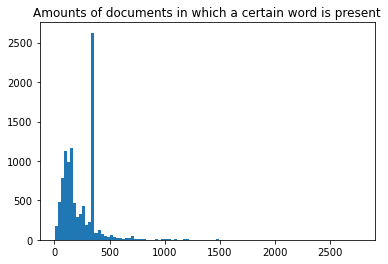

In [136]:
wordamount = np.count_nonzero(new_X, axis = 0)
plt.hist(wordamount, bins=100)
plt.title("Amounts of documents in which a certain word is present")

This is weird, let's have a look into the raw data

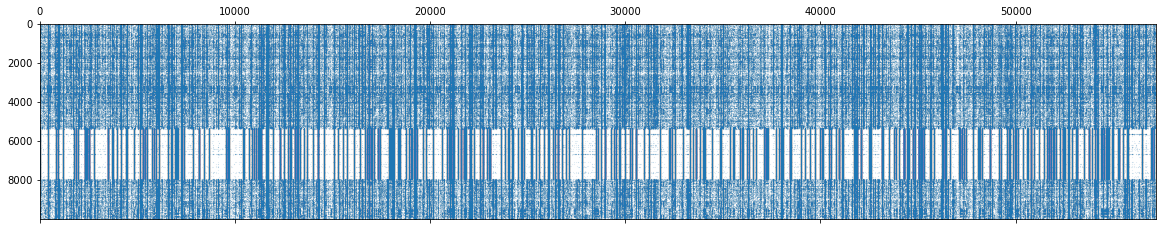

In [137]:
plt.figure(figsize=(20,5)) 
plt.spy(new_X.T, precision = 0.1, markersize = 0.03)
plt.show()

That looks fishy...

In [11]:
# how many duplicates are there?
X_duprm, indices, counts = np.unique(new_X, axis = 1, return_index = True, return_counts = True)
print(np.sort(counts)[-10:])

[   9   14   14   14   16   18   19   27   30 2524]


There are a few duplicates, but 2524 Mails are exactly the same!

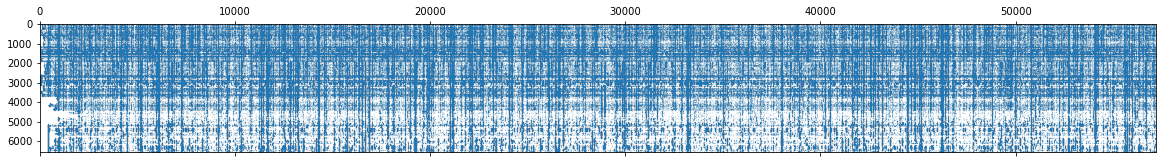

In [12]:
# since np.uniques returns the sorted duplicate free data, we can plot it again, this time sorted by labels
y_duprm = new_y[indices]
sorted_indices = np.argsort(y_duprm) #returns the indices that would sort an array
X_sorted = X_duprm[:,sorted_indices]
plt.figure(figsize=(20,5)) 
plt.spy(X_sorted.T, precision = 0.1, markersize = 0.03)
plt.show()

In [13]:
unique_categories, category_count = np.unique(y_duprm, return_counts=True)

dede = dict(zip(unique_categories, category_count))
print("Class distribution without duplicates (-1 = not spam; 1 = spam) :", dede)

Class distribution without duplicates (-1 = not spam; 1 = spam) : {-1: 1931, 1: 4643}


Having removed the duplicates, we can see, that the spam instances were reduced by more than 40% while the "normal" e-mails were only reduced by 2%. Since there are both pros and cons to keeping the duplicates and i don't know how the data was produced, I will test both versions.


#### Data normalisation

Since we are dealing with textual data, I chose the td-idf representation. Frequent words will not be as influential and words that only occur in few documents (i.e. e-mails) will get higher values. This hopefully helps with differentiating between spam and not-spam while "unhelpful" words don't get as much attention.

In [141]:
def tfidf(X):
    """Applies the tf-idf to the elements of a matrix or vector. 
    Input: numpy-array, Output: numpy-array """
    df = np.count_nonzero(X, axis=0)
    idf = np.log10(len(X) / df)
    tf = X # this could be also np.log10(X+1) (as proposed by Jurafsky et al. 2021) but it takes way longer
    tfidf = tf * idf
    return tfidf


In [142]:
# apply tfidf to both datasets
X_tfidf = tfidf(new_X)
X_tfidf_duprm = tfidf(X_duprm)

print(X_tfidf.shape, X_tfidf_duprm.shape)


(57173, 10000) (57173, 6574)


#### Feature selection

Finally, 57 000 features to find a binary decision seems kind of inefficient since for most cases, the values are 0 anyways. I will try to reduce the features and see how this affects the performance.

In [143]:
# I choose to remove the 10th percentile of words with respect to their overall frequency
crit = np.percentile(np.sum(X_tfidf, axis = 0), 10) 
X_reduced = X_tfidf[np.sum(X_tfidf, axis = 1)>crit,:]
X_reduced.shape

(4008, 10000)

This reduces our features to 4008!

#### Train/Testsetvalidation

In [144]:
from sklearn.model_selection import train_test_split
# whole dataset
X_train_whole, X_test_whole, y_train_whole, y_test_whole = train_test_split(X_tfidf.T, new_y, test_size=0.25, random_state=3)
# dataset without duplicates
X_train_rmdups, X_test_rmdups, y_train_rmdups, y_test_rmdups = train_test_split(X_tfidf_duprm.T, y_duprm, test_size=0.25, random_state=3)
# dataset with reduced features
X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(X_reduced.T, new_y, test_size=0.25, random_state=3)

## Random Baseline

In [145]:
def random_baseline(len, spam):
    predictions = np.ones(len)
    x = int(len * (1-spam))
    predictions[0:x] = -1
    random.shuffle(predictions)
    return predictions

In [146]:
random_preds = random_baseline(len(new_X[0]), category_count[1]/np.sum(category_count))

## Model instantiation: Support Vector Machine

-> why a SVM?

- not many instances
- many features
- powerful linear model

In [147]:
from sklearn.svm import SVC

clf_svm_whole = SVC()
clf_svm_rmdups = SVC()
clf_svm_red = SVC()

clf_svm_whole.fit(X_train_whole, y_train_whole)
print("Whole training finished!")
clf_svm_rmdups.fit(X_train_rmdups, y_train_rmdups)
print("Rmdups training finished!")
clf_svm_red.fit(X_train_red, y_train_red)
print("reduced feature training finished!")


Whole training finished!
Rmdups training finished!
reduced feature training finished!


## Model evaluation

In [148]:
def fpr_fun(y_test, y_preds, poslabel = 1, neglabel = -1):
    fp = np.sum(np.logical_and(y_preds == poslabel, y_test == neglabel))
    tn = np.sum(np.logical_and(y_preds == neglabel, y_test == neglabel))
    return fp/ (tn+fp)

First let's test our random model:

Accuracy: 0.6183
Precision: 0.7982443720798528
Recall: 0.7021170610211707
F_1: 0.7471013052408402
False-positive-rate:  0.7233502538071066


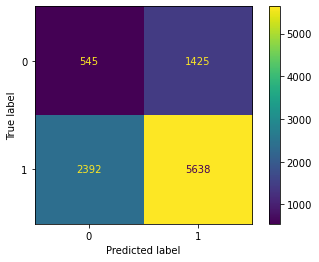

In [149]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics

cm = confusion_matrix(new_y, random_preds) 

cm_display = ConfusionMatrixDisplay(cm).plot()


acc = metrics.accuracy_score(new_y, random_preds)
p = metrics.precision_score(new_y, random_preds)
r = metrics.recall_score(new_y, random_preds)
f1 = metrics.f1_score(new_y, random_preds)

print("Accuracy: {}\nPrecision: {}\nRecall: {}\nF_1: {}".format(acc, p, r, f1))
print("False-positive-rate: ", fpr_fun(new_y, random_preds))

Now, let's test the three SVM with different input:

In [150]:
y_preds_whole = clf_svm_whole.predict(X_test_whole)
y_preds_rmdups = clf_svm_rmdups.predict(X_test_rmdups)
y_preds_red = clf_svm_red.predict(X_test_red)


print("Whole dataset:")
print(metrics.classification_report(y_test_whole, y_preds_whole ))
print("FPR whole: ", fpr_fun(y_test_whole, y_preds_whole))
print("------------------------------------------------------")
print("After removing duplicates:")
print(metrics.classification_report(y_test_rmdups, y_preds_rmdups))
print("FPR rmdups:",fpr_fun( y_test_rmdups, y_preds_rmdups))
print("------------------------------------------------------")
print("After reducing features")
print(metrics.classification_report(y_test_red, y_preds_red))
print("FPR red: ",fpr_fun( y_test_red, y_preds_red))

Whole dataset:
              precision    recall  f1-score   support

          -1       0.98      0.95      0.97       483
           1       0.99      1.00      0.99      2017

    accuracy                           0.99      2500
   macro avg       0.99      0.97      0.98      2500
weighted avg       0.99      0.99      0.99      2500

FPR whole:  0.049689440993788817
------------------------------------------------------
After removing duplicates:
              precision    recall  f1-score   support

          -1       0.99      0.92      0.95       469
           1       0.97      0.99      0.98      1175

    accuracy                           0.97      1644
   macro avg       0.98      0.96      0.97      1644
weighted avg       0.97      0.97      0.97      1644

FPR rmdups: 0.07889125799573561
------------------------------------------------------
After reducing features
              precision    recall  f1-score   support

          -1       0.99      0.95      0.97       

Removing the duplicates does not help the model performance, which is to be expected since the duplicate instance will be present in both training and testing data and thus "boosting" the performance. Interestingly, the removal of features does not change anything apparent, the fpr is just slightly higher. Still, the fpr is under the desired threshold of 0.002.

Let's take the model with reduced features and penalize false positives by tuning the class weight parameter.

FPR for class weight of 1 = 0.053830227743271224
FPR for class weight of 10 = 0.004140786749482402
FPR for class weight of 50 = 0.002070393374741201
FPR for class weight of 100 = 0.0
FPR for class weight of 500 = 0.0


Text(0.5, 1.0, 'Receiver Operating Characteristic')

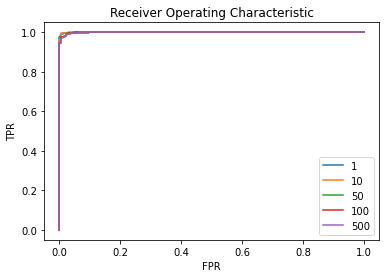

In [151]:
from sklearn.metrics import roc_curve

weights = [1,10, 50, 100, 500]

for w in weights:

    classdict = {1 : 1, -1 : w}
    clf = SVC(class_weight = classdict)
    clf.fit(X_train_red, y_train_red)
    y_preds = clf.predict(X_test_red)
    fpr_overall = fpr_fun( y_test_red, y_preds)
    y_score = clf.decision_function(X_test_red)
    fpr , tpr, thresholds = roc_curve(y_test_red, y_score)
    plt.plot(fpr, tpr, label= w)
    print("FPR for class weight of {} = {}".format(w, fpr_overall))


plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('Receiver Operating Characteristic')


## Conclusions

- Any SVM performs better than the random baseline in all important parameters (fpr and recall both 0.8)
- reducing the features does not harm the performance and makes training more efficient since there are less irrelevant features to iterate over
- adding a class weight >50 to the not-spam category to penalize false positives helps lowering the fpr under the required threshold

## Bibliography

Jurafsky and Martin 2021: Speech and Language Processing - An Introduction to Natural Language Processing, Computational Linguistics, and Speech Recognition, Third Edition draft. Available at [https://web.stanford.edu/~jurafsky/slp3/]. Last retrieved February 2022.